In [1]:
import os
import numpy as np
import torch
from nilearn import plotting
import data
import visualize
from words import make_classifications, Predictions
from data import normalize_fmri_data, unnormalize_fmri_data
from LEM import extract_data_features, predAccuracy
from numpy.linalg import norm


In [2]:
class argObj:
    def __init__(self, data_dir, parent_submission_dir, subj):
        self.subj = format(subj, '02')
        self.data_dir = os.path.join(data_dir, 'subj' + self.subj)
        self.parent_submission_dir = parent_submission_dir
        self.subject_submission_dir = os.path.join(self.parent_submission_dir,
                                                   'subj' + self.subj)


In [3]:
platform = 'jupyter_notebook'

device = "cuda"
torch.cuda.set_device(device)
# setting up the directories and ARGS
data_dir = ''#../MQP/algonauts_2023_challenge_data/'
parent_submission_dir = '../submission'
subj = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
# args

args = argObj(data_dir, parent_submission_dir, subj)
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

words = ['furniture', 'food', 'kitchenware', 'appliance', 'person', 'animal', 'vehicle', 'accessory',
            'electronics', 'sports', 'traffic', 'outdoor', 'home', 'clothing', 'hygiene', 'toy', 'plumbing', 
             'computer', 'fruit', 'vegetable', 'tool']


In [4]:
print("________ Process Data ________")

# Normalize Data Before Split
lh_fmri, lh_data_min, lh_data_max = normalize_fmri_data(lh_fmri)
print(lh_fmri)
print("- - - - - - - -")
rh_fmri, rh_data_min, rh_data_max = normalize_fmri_data(rh_fmri)
print(rh_fmri)

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

train_img_dir = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir = os.path.join(args.data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
# train_img_list = train_img_list[:2500]
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()

print('\nTraining images: ' + str(len(train_img_list)))
print('\nTest images: ' + str(len(test_img_list)))
train_img_file = train_img_list[0]
print('\nTraining image file name: ' + train_img_file)
print('\n73k NSD images ID: ' + train_img_file[-9:-4])

________ Process Data ________
-2.515819 2.4762304
[[    0.33133     0.46326     0.37849 ...      0.2802     0.31058     0.48424]
 [    0.64868     0.44725     0.68909 ...     0.73208     0.73593     0.78369]
 [    0.44218     0.31722     0.84834 ...     0.43348     0.40331     0.46675]
 ...
 [    0.62769     0.55193     0.67142 ...     0.69863     0.72638     0.71742]
 [    0.44796     0.47105     0.62229 ...     0.55655     0.54892     0.62596]
 [    0.22312     0.42925     0.37006 ...     0.63066     0.60185     0.55653]]
- - - - - - - -
-2.5166664 2.4293716
[[    0.87571     0.39814     0.50907 ...     0.42413     0.38705     0.37228]
 [    0.61258     0.70873     0.49787 ...     0.80909     0.83579     0.84486]
 [    0.75225     0.48751     0.24973 ...     0.58831     0.62981     0.64943]
 ...
 [    0.50022     0.60346     0.57408 ...     0.57377     0.50956     0.43088]
 [    0.84737     0.50435      0.4118 ...     0.49836      0.5347     0.54115]
 [     0.4397     0.60309     0.

In [5]:
print("________ Split Data ________")

idxs_train, idxs_val, idxs_test = data.splitdata(train_img_list, test_img_list, train_img_dir)
lh_fmri_train = lh_fmri[idxs_train]
rh_fmri_train = rh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_val = rh_fmri[idxs_val]
lh_fmri_test = lh_fmri[idxs_test]
rh_fmri_test = rh_fmri[idxs_test]

________ Split Data ________
Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159


In [6]:
print("________ Make Lists ________")

train_images = data.makeList(train_img_dir, train_img_list, idxs_train)
val_images = data.makeList(train_img_dir, train_img_list, idxs_val)
test_images = data.makeList(test_img_dir, test_img_list, idxs_test)
torch.cuda.empty_cache()

________ Make Lists ________


In [7]:
print("________ Make Classifications ________")
lh_classifications = make_classifications(train_images, idxs_train, device)
rh_classifications = lh_classifications
lh_classifications_val = make_classifications(val_images, idxs_val, device)
rh_classifications_val = lh_classifications_val
lh_classifications_test = make_classifications(test_images, idxs_test, device)
rh_classifications_test = lh_classifications_test

torch.cuda.empty_cache()

________ Make Classifications ________
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'k

In [8]:
print("________ Extract Image Features ________")

train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader = (
    data.transformData(train_img_dir, test_img_dir, idxs_train, idxs_val, idxs_test, 64))

features_train, features_val, features_test = (
    extract_data_features(train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader, 64, device))

________ Extract Image Features ________


Extracting Features: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Training images features:
(8857, 64)
(Training stimulus images × PCA features)

Validation images features:
(984, 64)
(Validation stimulus images × PCA features)

Test images features:
(159, 64)
(Test stimulus images × PCA features)


In [9]:
print("________ Organize Input________")

dftrainL, dftrainFL = data.organize_input(lh_classifications, features_train, lh_fmri_train)
dftrainR, dftrainFR = data.organize_input(rh_classifications, features_train, rh_fmri_train)

dfvalL, dfvalFL = data.organize_input(lh_classifications_val, features_val, lh_fmri_val)
dfvalR, dfvalFR = data.organize_input(rh_classifications_val, features_val, rh_fmri_val)

dftestL, dftestFL = data.organize_input(lh_classifications_test, features_test, lh_fmri_test)
dftestR, dftestFR = data.organize_input(rh_classifications_test, features_test, rh_fmri_test)

________ Organize Input________
      0   1          2          3          4          5          6   \
0      0   4  -9.321003  44.642829  22.217134  -2.073526  -3.367402   
1     32   9  16.955515   2.825685 -40.212460  34.323994  -6.674869   
2      2   6   6.113836  31.824434   1.759395 -14.278148   9.048601   
3     16   5  15.961992 -16.817053  12.893243  -5.222069   1.945720   
4     48   1 -50.367944 -47.220425  47.776146  43.123541  19.358334   
...   ..  ..        ...        ...        ...        ...        ...   
8852   0   4  19.101748  20.870800 -21.817514  28.619204 -23.669634   
8853  28   7 -20.417551  40.790340  13.635369   9.716242 -27.836735   
8854   0   4  18.231681  -1.134378 -26.731813  -5.119928  21.444115   
8855   7   6  25.460120  47.921351  45.552843  -4.164881   3.226851   
8856   0   4 -28.384371 -12.319484 -17.732330  32.418812 -32.245701   

             7          8          9   ...         56         57         58  \
0    -16.816080 -15.240964   0.32381

In [10]:
print("________ Predictions Validation ________")
lh_fmri_val_pred = Predictions(dftrainL, dftrainFL, dfvalL, dfvalFL)
rh_fmri_val_pred = Predictions(dftrainR, dftrainFR, dfvalR, dfvalFR)

________ Predictions Validation ________
PREDICTIONS
[[    0.58582     0.46208     0.55602 ...     0.44695      0.4853     0.39012]
 [    0.53031     0.41261     0.20612 ...     0.38756     0.31653     0.46265]
 [     0.5813     0.64572     0.65082 ...     0.50731     0.49914     0.45125]
 ...
 [    0.20881       0.295     0.47646 ...     0.36801     0.29388     0.39038]
 [     0.5874     0.46502     0.63557 ...     0.48936     0.48192     0.58774]
 [    0.60275     0.54152     0.52044 ...     0.54478     0.66644     0.52105]] 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 [[    0.54284     0.55622     0.62617 ...     0.59834     0.59137     0.55541]
 [    0.49799     0.46861     0.45105 ...     0.48964     0.49052     0.49499]
 [    0.55867     0.56202     0.54528 ...     0.51152     0.52237     0.49661]
 ...
 [    0.50769     0.46251     0.42856 ...     0.41436     0.42375     0.45352]
 [     0.5192     0.49442     0.47075 ...     0.50641     0.50684     0.51204]
 [    0.57642     0.51573     0.39

In [11]:
print("________ Predictions Test________")
lh_fmri_test_pred = Predictions(dftrainL, dftrainFL, dftestL, dftestFL)
rh_fmri_test_pred = Predictions(dftrainR, dftrainFR, dftestR, dftestFR)

________ Predictions Test________
PREDICTIONS
[[    0.33133     0.46326     0.37849 ...      0.2802     0.31058     0.48424]
 [    0.64868     0.44725     0.68909 ...     0.73208     0.73593     0.78369]
 [    0.44218     0.31722     0.84834 ...     0.43348     0.40331     0.46675]
 ...
 [    0.31642     0.28488     0.37538 ...     0.38776     0.34312     0.41256]
 [    0.41328     0.53082     0.62215 ...      0.7056     0.70056     0.66135]
 [    0.59368     0.51872      0.7144 ...     0.37513     0.32682      0.2032]] 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 [[    0.53204     0.46033      0.3801 ...      0.5252     0.51887     0.55865]
 [    0.48874      0.4872     0.56344 ...     0.60145     0.58863     0.56765]
 [    0.48249     0.46559     0.50357 ...     0.49641      0.4874     0.49456]
 ...
 [    0.48849     0.48393      0.6753 ...     0.58147     0.57236     0.54808]
 [    0.50198     0.49788      0.3964 ...     0.40099     0.40805     0.44135]
 [    0.45664      0.4671     0.54047 ...

In [12]:
print("________ Unnormalize Data ________")

lh_fmri_val_pred = unnormalize_fmri_data(lh_fmri_val_pred, lh_data_min, lh_data_max)
rh_fmri_val_pred = unnormalize_fmri_data(rh_fmri_val_pred, rh_data_min, rh_data_max)
lh_fmri_test_pred = unnormalize_fmri_data(lh_fmri_test_pred, lh_data_min, lh_data_max)
rh_fmri_test_pred = unnormalize_fmri_data(rh_fmri_test_pred, rh_data_min, rh_data_max)


________ Unnormalize Data ________


In [13]:
print("________ Re-Load Data ________")
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_val = rh_fmri[idxs_val]

lh_fmri_test = lh_fmri[idxs_train]
rh_fmri_test = rh_fmri[idxs_train]
print(lh_fmri_test)


________ Re-Load Data ________
[[    0.40842     0.60459       0.469 ...    -0.11772    -0.16012     0.26567]
 [    0.28022    -0.20454    -0.23246 ...    -0.49602    -0.37053     0.82298]
 [     1.2146      1.2275     0.74717 ...     0.73729     0.92201     0.95088]
 ...
 [   0.083842     -0.1186   -0.096672 ...    -0.17723    -0.16337     0.70648]
 [     0.8098     0.94027    -0.13669 ...     0.27384     0.17184       1.139]
 [    0.12311     0.38251    -0.12412 ...     -0.2804    -0.68326     -1.3271]]


In [14]:
print("________ Prediction Accuracy ________")

lh_correlation, rh_correlation = predAccuracy(lh_fmri_val_pred, lh_fmri_val, rh_fmri_val_pred, rh_fmri_val)


________ Prediction Accuracy ________
Start PredAccuracy

predicted
 [[    0.19407     0.26088     0.61005 ...     0.47112     0.43633      0.2568]
 [  -0.029829    -0.17649    -0.26413 ...   -0.071505   -0.067121   -0.044782]
 [    0.27307     0.28982     0.20626 ...    0.037694    0.091864   -0.036718]
 ...
 [   0.018585    -0.20694    -0.37643 ...    -0.44734    -0.40041    -0.25182]
 [    0.07604   -0.047655    -0.16583 ...    0.012203    0.014355     0.04029]
 [    0.36171    0.058726    -0.54908 ...   -0.047368  -0.0087066   -0.046618]] 
actual
 [[     0.4086    -0.20907     0.25986 ...    -0.28465    -0.09316     -0.5683]
 [     0.1315    -0.45603     -1.4868 ...    -0.58112     -0.9357    -0.20625]
 [    0.38604     0.70764     0.73312 ...    0.016718   -0.024067    -0.26313]
 ...
 [    -1.4735     -1.0432    -0.13728 ...     -0.6787     -1.0488    -0.56705]
 [    0.41654    -0.19443       0.657 ...   -0.072899    -0.11006     0.41819]
 [    0.49314     0.18747    0.082219 ... 

100%|██████████| 20544/20544 [00:16<00:00, 1251.45it/s]

average lh  38.7457844547927 average rh  39.00844358461057


________ Visualize Each Class ________
0 furniture


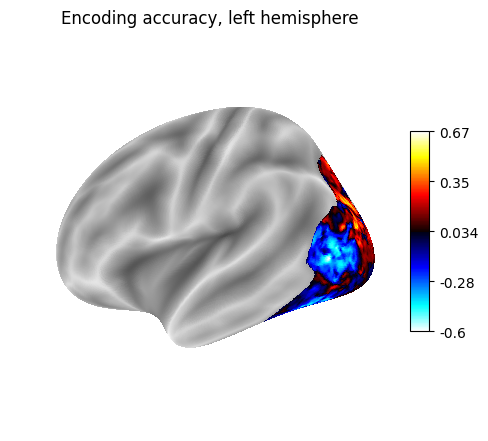

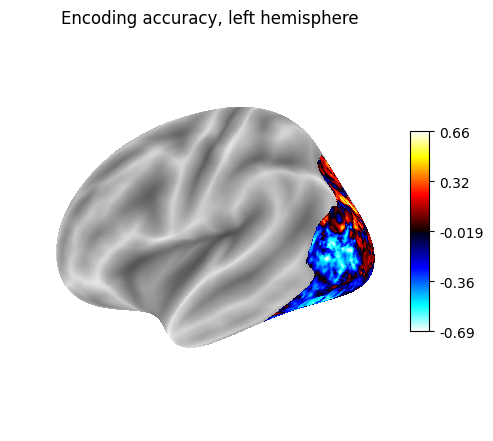

33
Corre  0.20888508771515132
Cosine Similarity: 0.8193502973711814
1 food


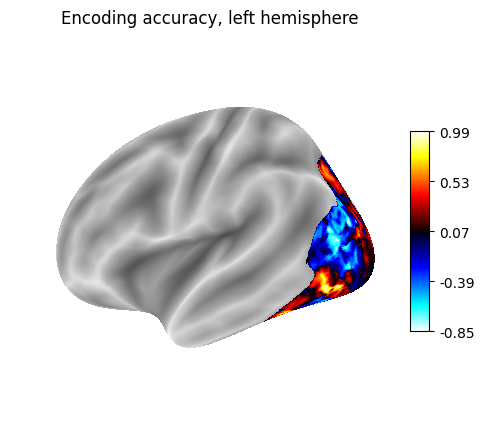

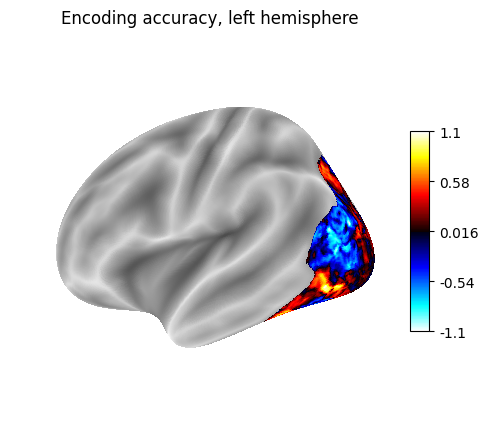

35
Corre  0.4614211997668715
Cosine Similarity: 0.9589897995666585
2 kitchenware


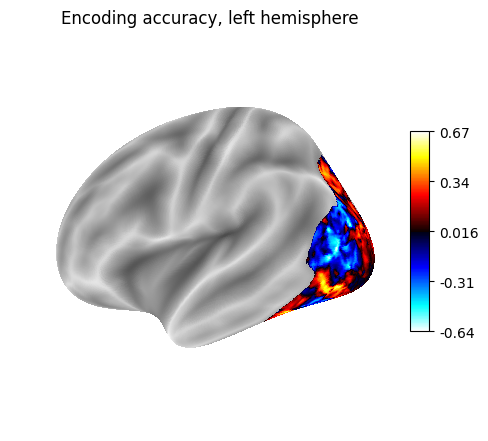

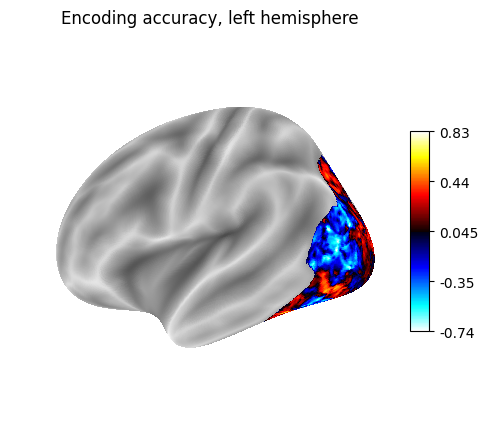

42
Corre  0.25789499846833963
Cosine Similarity: 0.9423646803466441
3 appliance


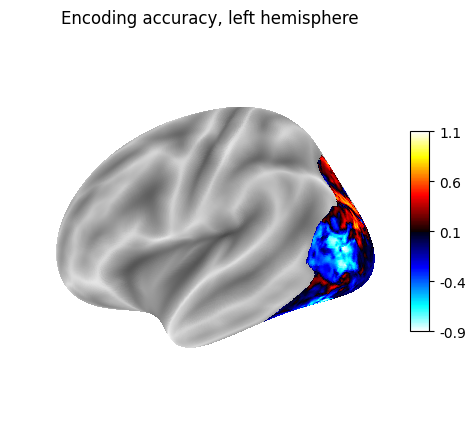

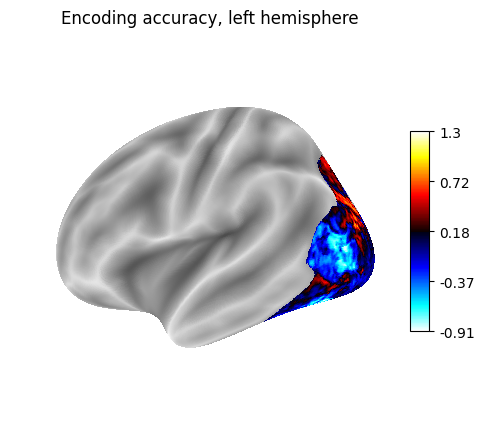

30
Corre  0.4556500486994762
Cosine Similarity: 0.9496741647886929
4 person


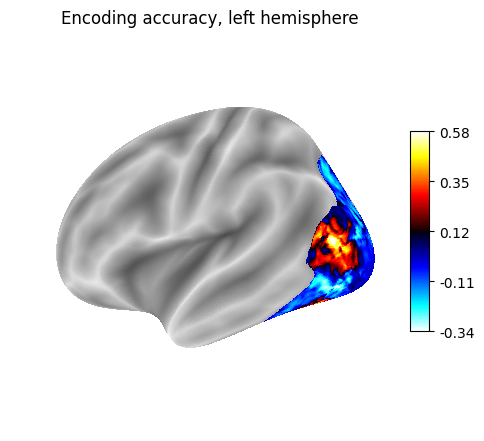

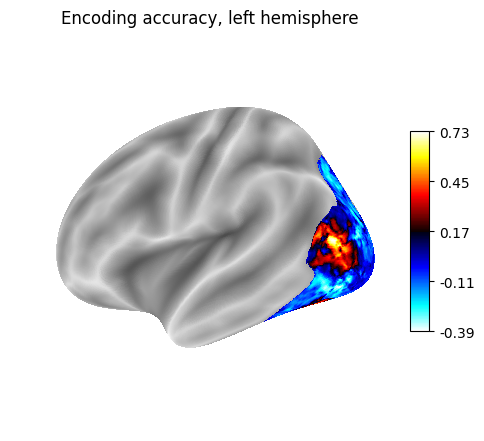

302
Corre  0.11212080895025031
Cosine Similarity: 0.9794548969335124
5 animal


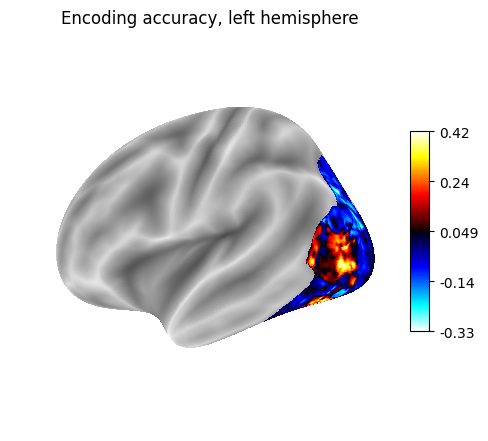

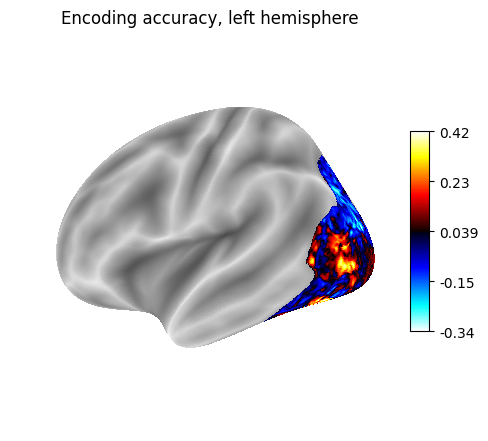

176
Corre  0.08669851802963793
Cosine Similarity: 0.9042451418967093
6 vehicle


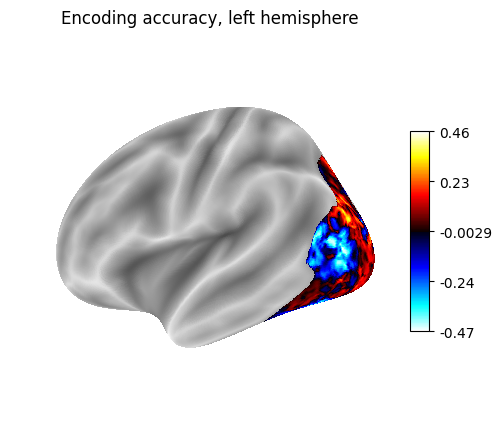

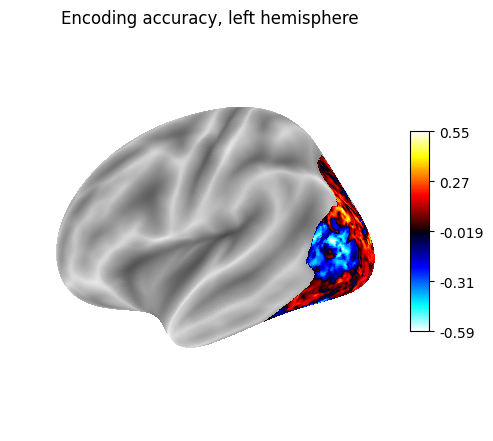

123
Corre  0.15398043236968287
Cosine Similarity: 0.9478237066307392
7 accessory


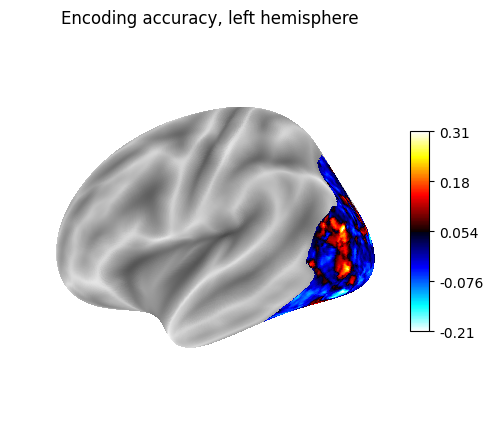

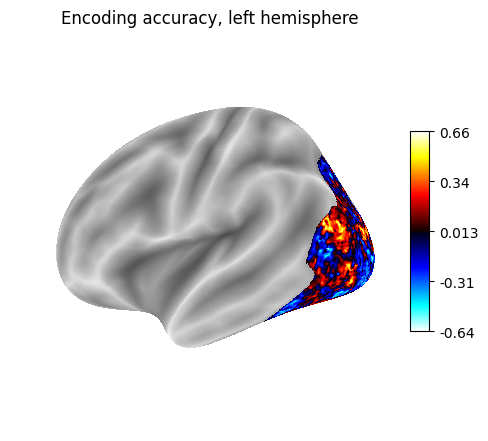

14
Corre  0.08200426564081857
Cosine Similarity: 0.5681666025901474
8 electronics


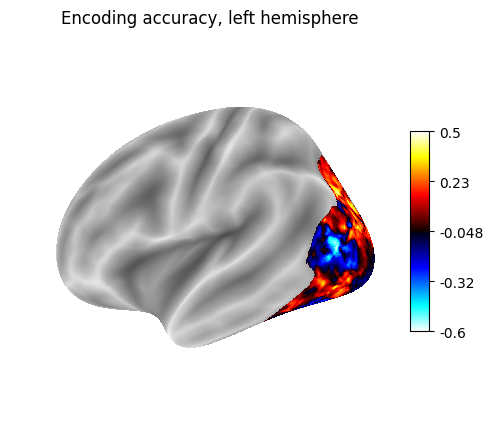

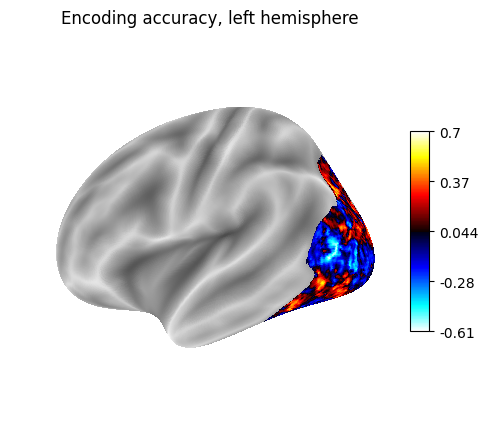

29
Corre  0.1616227980355376
Cosine Similarity: 0.8230128482100971
9 sports


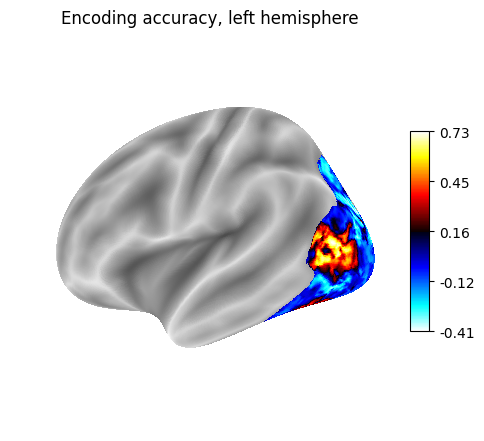

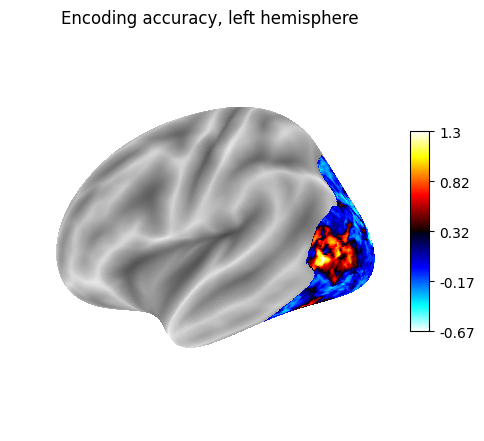

36
Corre  0.21895582020308454
Cosine Similarity: 0.9037871210297578
10 traffic


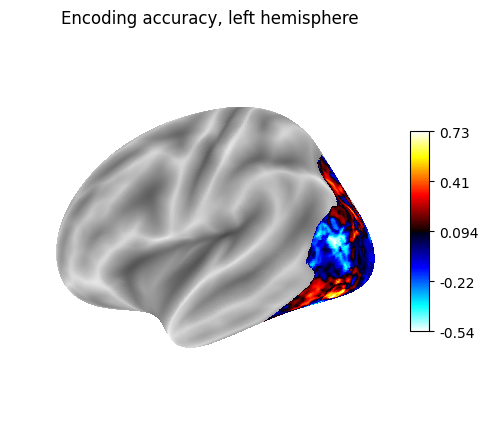

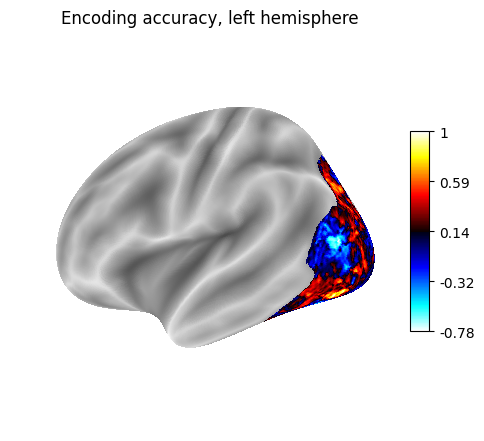

19
Corre  0.2170851530730577
Cosine Similarity: 0.8220716981083862
11 outdoor


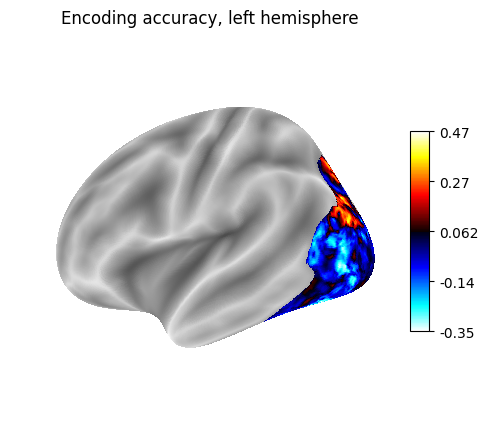

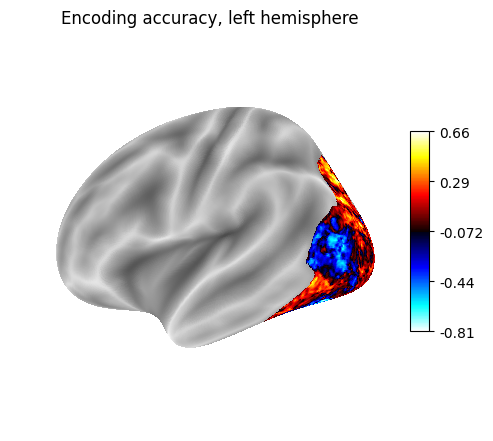

18
Corre  0.22511097326042975
Cosine Similarity: 0.7329154114564644
12 home


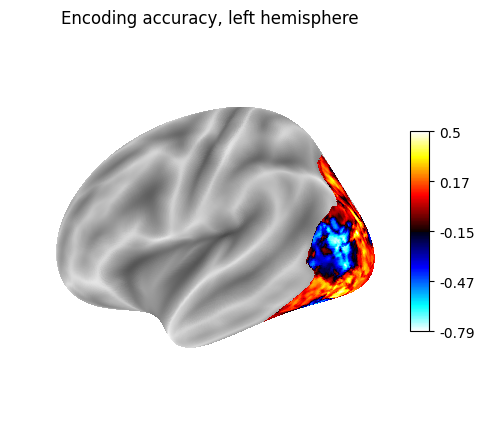

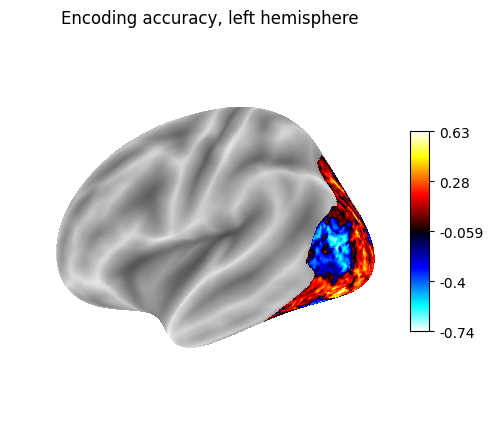

34
Corre  0.23876261911076124
Cosine Similarity: 0.8916542265852013
13 clothing


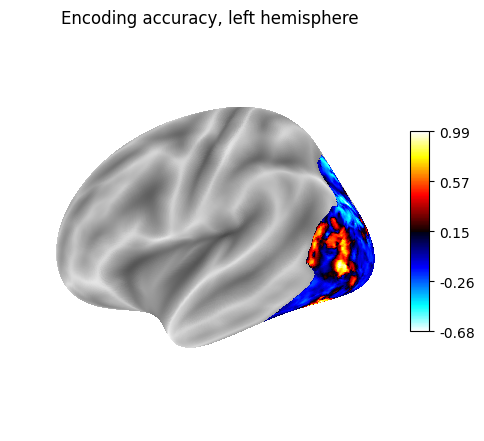

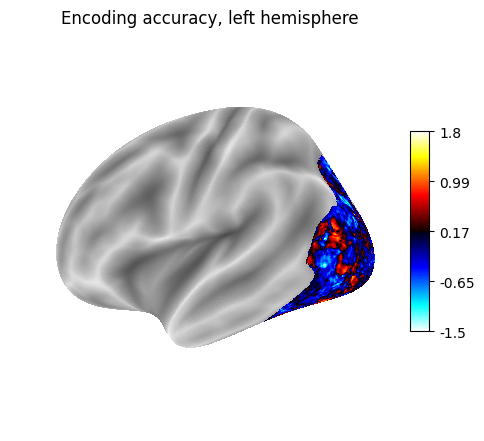

3
Corre  0.4222909239145659
Cosine Similarity: 0.5949564926993413
14 hygiene


/home/vislab-004/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vislab-004/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


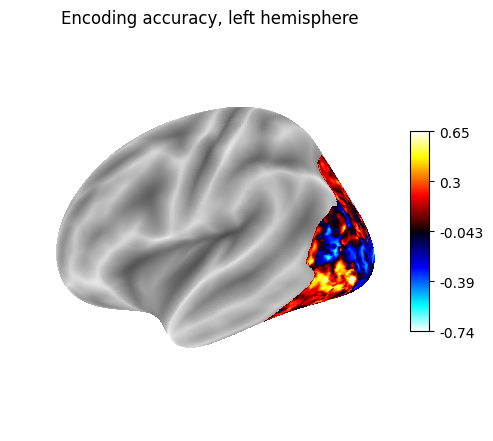

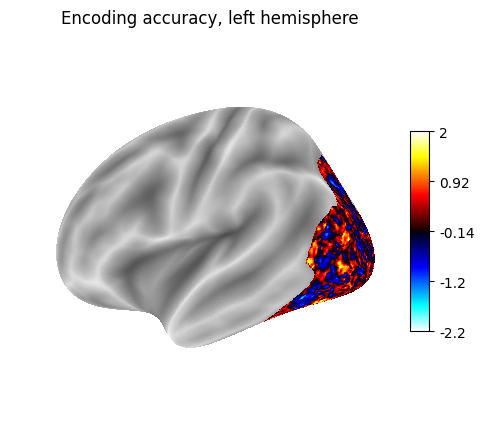

1
Corre  0.6345467263759939
Cosine Similarity: 0.26865006093542393
15 toy


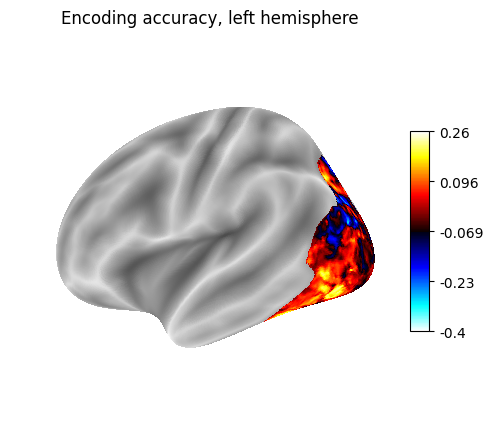

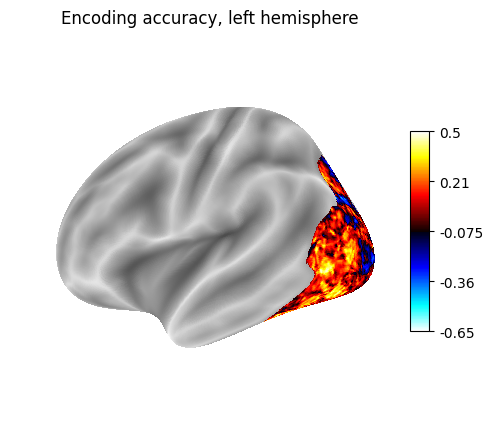

30
Corre  0.08434894559490103
Cosine Similarity: 0.7066033849014035
16 plumbing


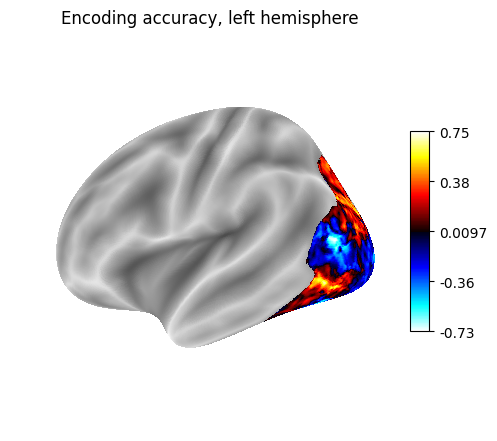

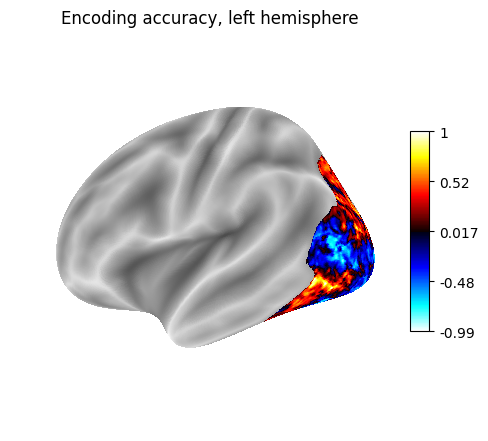

19
Corre  0.44884981426280923
Cosine Similarity: 0.9126271853069823
17 computer


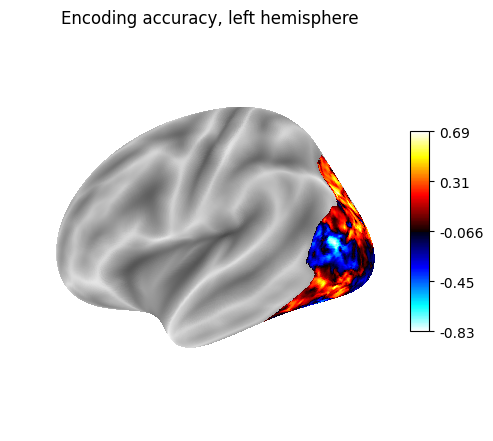

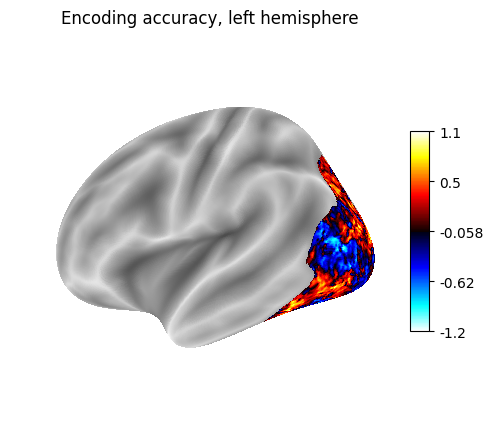

6
Corre  0.3564412451145162
Cosine Similarity: 0.7325393992954118
18 fruit


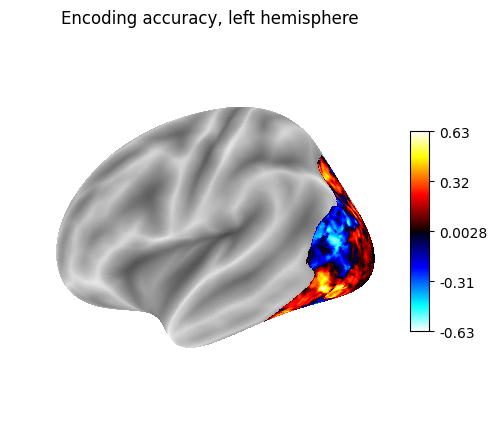

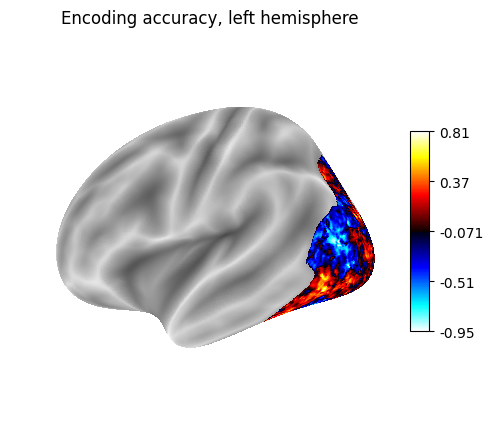

14
Corre  0.2523328022199945
Cosine Similarity: 0.7175045412360119
19 vegetable


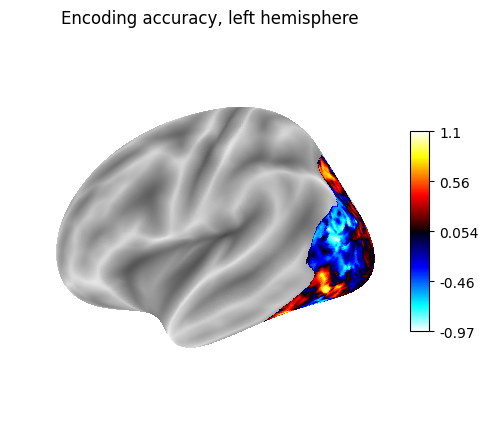

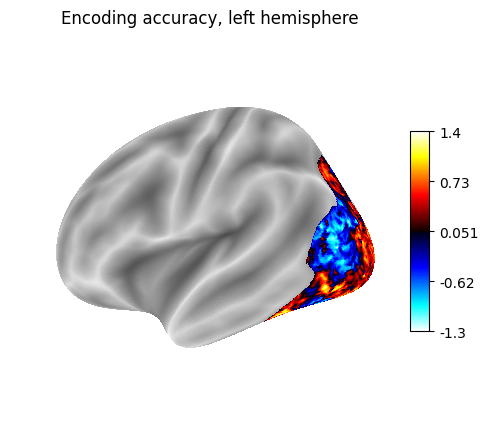

7
Corre  0.6263515918375318
Cosine Similarity: 0.8511522958731367
20 tool


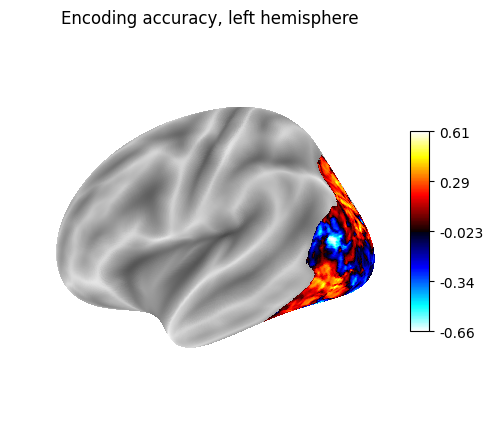

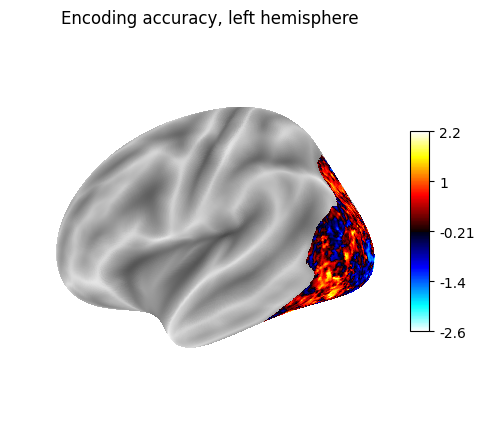

1
Corre  0.7918709055168336
Cosine Similarity: 0.5799536469807371
________ END ________


In [15]:
print("________ Visualize Each Class ________")

length = len(words)
for clss in range(length):
    print(clss, words[clss])
    avg_lh_pred = []
    avg_lh_real = []
    avg_rh_pred = []
    avg_rh_real = []
    for i in range(len(lh_classifications_val)):

        if lh_classifications_val[i][1] == clss:
            avg_lh_pred.append(lh_fmri_val_pred[i])
            avg_lh_real.append(lh_fmri_val[i])

        if rh_classifications[i][1] == clss:
            avg_rh_pred.append(rh_fmri_val_pred[i])
            avg_rh_real.append(lh_fmri_val[i])

    if(len(avg_lh_pred)  == 0):
        pass
    else:
        lh = np.mean(avg_lh_pred, axis=0)
        rh = np.mean(avg_rh_pred, axis=0)

        #print("MEAN PRED LH:\n", lh)
        #print("MEAN PRED RH:\n", rh)
        visualize.plot_predictions(args, lh, rh)
        lh2 = np.mean(avg_lh_real, axis=0)
        rh2 = np.mean(avg_rh_real, axis=0)

        #print("MEAN REAL LH:\n", lh2)
        #print("MEAN REAL RH:\n", rh2)
        visualize.plot_predictions(args, lh2, rh2)
        plotting.show()

        corr = np.corrcoef(avg_lh_pred, avg_lh_real)
        print(len(avg_lh_pred))
        print("Corre ", np.mean(corr))
        cosine = np.dot(lh,lh2)/(norm(lh)*norm(lh2))
        print("Cosine Similarity:", cosine)
        torch.cuda.empty_cache()

print("________ END ________")

In [16]:
print("________ Visualize Each Class ________")

length = len(words)
for clss in range(length):
    print(clss, words[clss])
    avg_lh_pred = []
    avg_lh_real = []
    avg_rh_pred = []
    avg_rh_real = []
    for i in range(len(lh_classifications_test)):

        if lh_classifications_test[i][1] == clss:
            avg_lh_pred.append(lh_fmri_test_pred[i])
            avg_lh_real.append(lh_fmri_test[i])

        if rh_classifications[i][1] == clss:
            avg_rh_pred.append(rh_fmri_test_pred[i])
            avg_rh_real.append(lh_fmri_test[i])

    if(len(avg_lh_pred)  == 0):
        pass
    else:
        lh = np.mean(avg_lh_pred, axis=0)
        rh = np.mean(avg_rh_pred, axis=0)

        #print("MEAN PRED LH:\n", lh)
        #print("MEAN PRED RH:\n", rh)
        visualize.plot_predictions(args, lh, rh)
        lh2 = np.mean(avg_lh_real, axis=0)
        rh2 = np.mean(avg_rh_real, axis=0)

        #print("MEAN REAL LH:\n", lh2)
        #print("MEAN REAL RH:\n", rh2)
        visualize.plot_predictions(args, lh2, rh2)
        plotting.show()

        corr = np.corrcoef(avg_lh_pred, avg_lh_real)
        print(len(avg_lh_pred))
        print("Corre ", np.mean(corr))
        cosine = np.dot(lh,lh2)/(norm(lh)*norm(lh2))
        print("Cosine Similarity:", cosine)
        torch.cuda.empty_cache()

print("________ END ________")

________ Visualize Each Class ________
0 furniture


KeyboardInterrupt: 